In [1]:
library(tidyverse)
library(progress)
library(nout)

source("../R/utils_data.R")
source("../R/utils_experiments.R")
source("../R/utils_g.R")

── Attaching core tidyverse packages ────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Demo

## Generate scores and plot them

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


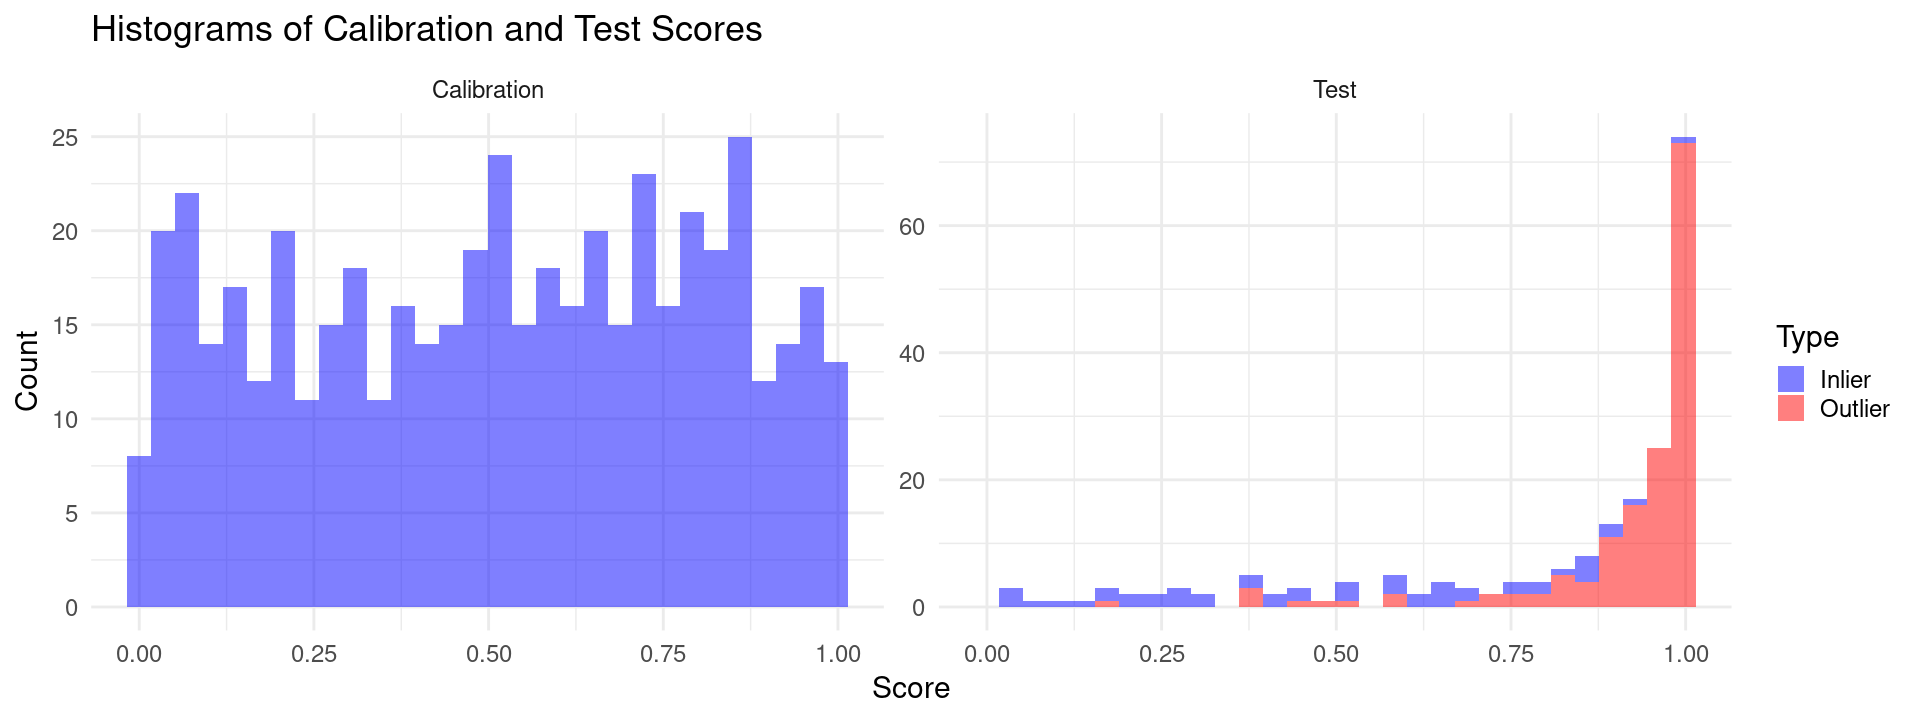

In [61]:
#set.seed(123) # For reproducibility

# Choose alternative distribution
#alternative <- "uniform"     #
#alternative <- "lehmann_k3"  #
#alternative <- "beta_0.25_0.25"     #
#alternative <- "beta_4_4"     #
alternative <- "normal_2_1"
#alternative <- "normal_-2_1"
#alternative <- "normal_-0.5_0.2"
#alternative <- "normal_0_0.25"
#alternative <- "normal_0_2"

# Generate a calibration set of inliers from a uniform distribution 
# and a test set containing a mixture of inliers and outliers from a different distribution.
data <- generate_cal_test_scores(n_cal = 500, n_test = 200, prop_out = 0.75, alternative = alternative)

# Prepare the data for plotting with an additional column for inliers/outliers
calibration_df <- tibble(score = data$scores.cal, set = "Calibration", type = "Inlier")
test_df <- tibble(score = data$scores.test, set = "Test", type = ifelse(data$outlier.test == 1, "Outlier", "Inlier"))
plot_data <- bind_rows(calibration_df, test_df)

# Adjust plot size
options(repr.plot.width = 16, repr.plot.height = 6)

# Create side-by-side histograms
ggplot(plot_data, aes(x = score, fill = type)) +
  geom_histogram(alpha = 0.5) +
  facet_wrap(. ~ set, scales = "free_y") +
  theme_minimal(base_size = 18) +  # Increase base font size
  labs(title = "Histograms of Calibration and Test Scores",
       x = "Score",
       y = "Count",
       fill = "Type") +
  scale_fill_manual(values = c("Inlier" = "blue", "Outlier" = "red"))

density_oracle <- function(x) density_scores(x, alternative)

## Monotone oracle density

In [62]:
plot_density <- function(function_list) {
  # Generate a sequence of values between 0 and 1
  x_values <- seq(0, 1, length.out = 1000)
  
  # Create an empty list to store plot data
  plot_data_list <- list()
  
  # Loop through each function in the list
  for (function_name in names(function_list)) {
    my_function <- function_list[[function_name]]
    
    # Evaluate the function at these points
    y_values <- sapply(x_values, my_function)
    
    # Add padding values
    x_values_padded <- c(-1e-2, -1e-6, x_values, 1 + 1e-6, 1 + 1e-2)
    y_values_padded <- c(0, 0, y_values, 0, 0)
    
    # Create a data frame for the current function
    plot_data <- data.frame(x = x_values_padded, y = y_values_padded, function_name = function_name)
    
    # Add to the list
    plot_data_list[[function_name]] <- plot_data
  }
  
  # Combine all data frames into one
  combined_plot_data <- do.call(rbind, plot_data_list)
  
  # Plot the functions with different colors
  ggplot(combined_plot_data, aes(x = x, y = y, color = function_name)) +
    geom_line() +
    ylim(0, NA) +
    theme_minimal(base_size = 15) +
    labs(title = "Plot of Density Functions from 0 to 1",
         x = "x",
         y = "Probability density") +
    scale_color_discrete(name = "Density")
}

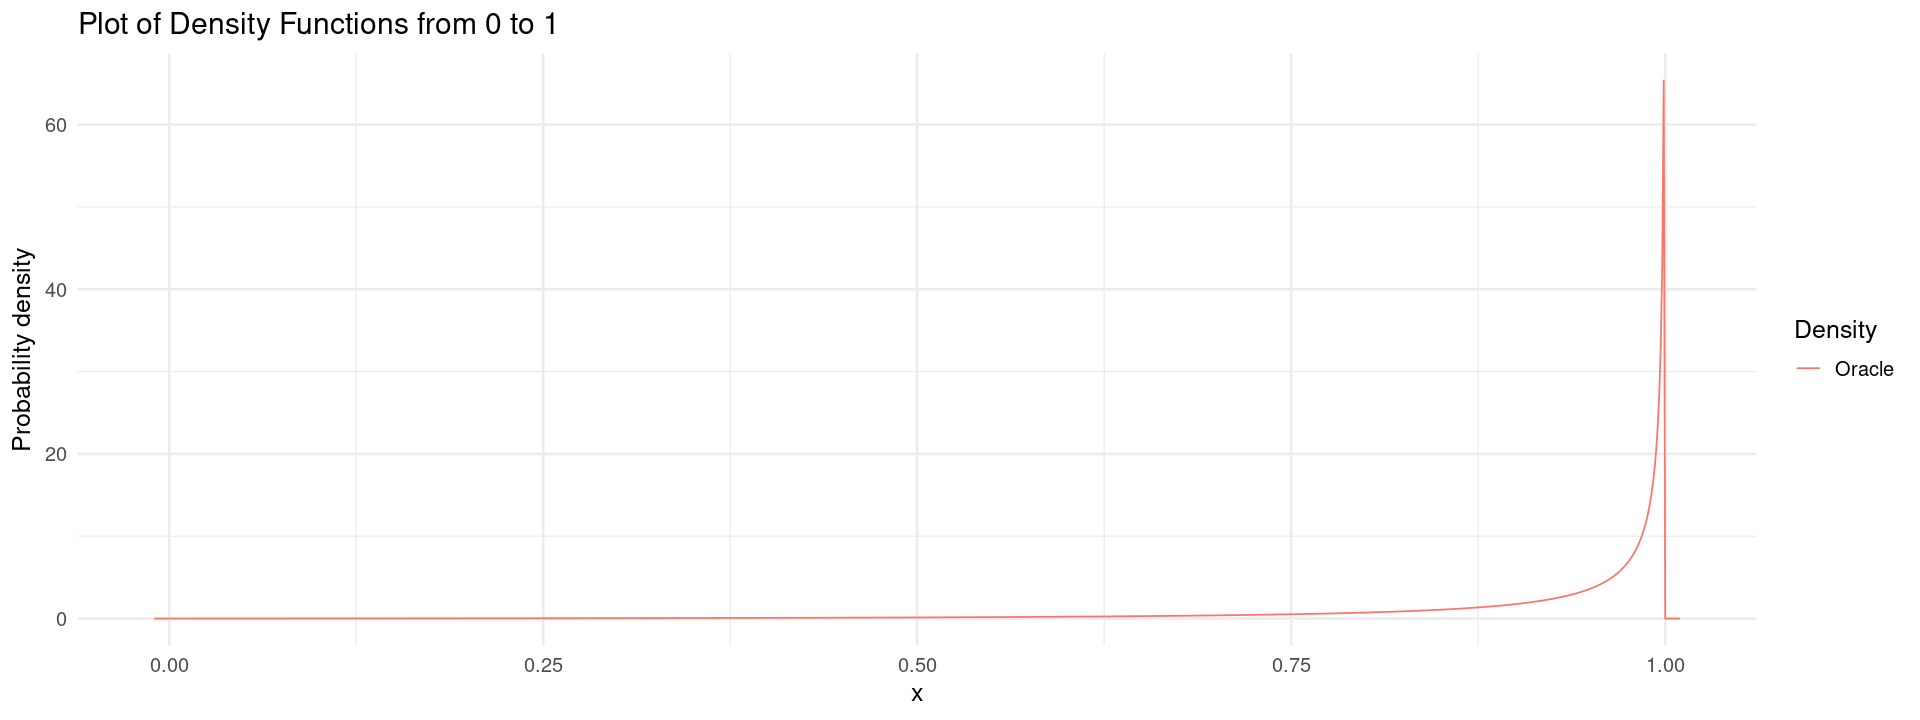

In [63]:
plot_density(list(Oracle=density_oracle))

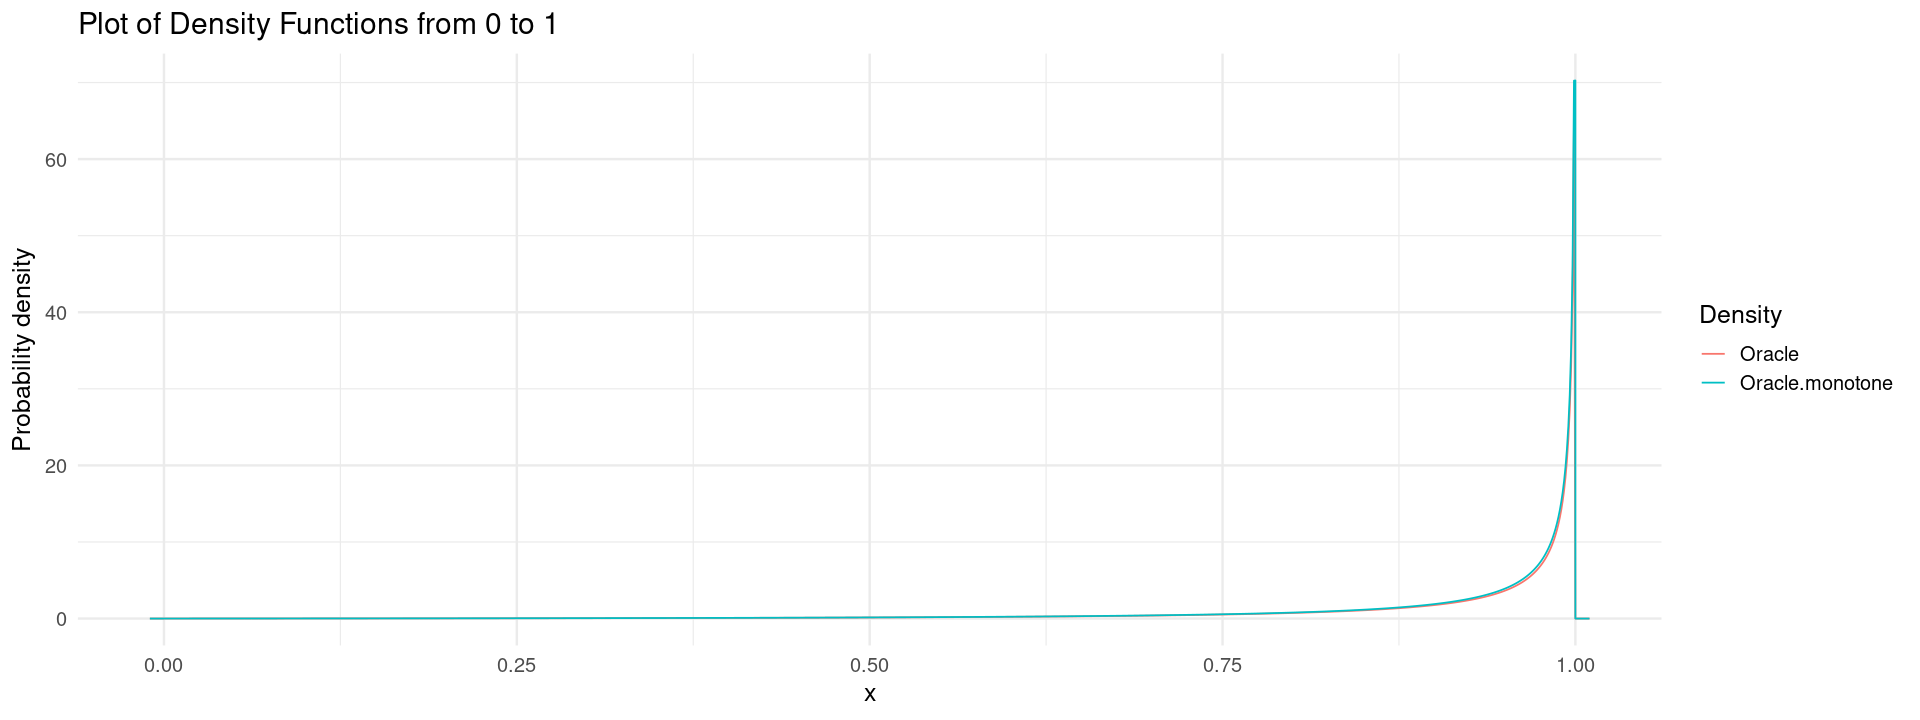

In [64]:
## Function to make density function monotone
make_density_monotone <- function(g) {
  tol = 1e-3
  x.grid <- seq(tol,1-tol,length.out=1000)
    
  ## Obtain density estimates from the model
  g.hat.values <- list(x=x.grid, y=g(x.grid))
  
  ## Create a monotone interpolation function
  iso_fit <- isoreg(g.hat.values$x, g.hat.values$y)
  g.hat.u <- approxfun(iso_fit$x, iso_fit$yf, method = "linear", rule = 2)
  
  ## Normalize the density
  integral <- integrate(g.hat.u, 0, 1)$value
  g.mon <- function(x) g.hat.u(x) / integral
  
  return(g.mon)
}

density_oracle_mono <- make_density_monotone(density_oracle)
plot_density(list(Oracle=density_oracle, Oracle.monotone=density_oracle_mono))

## Monotone density estimation

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


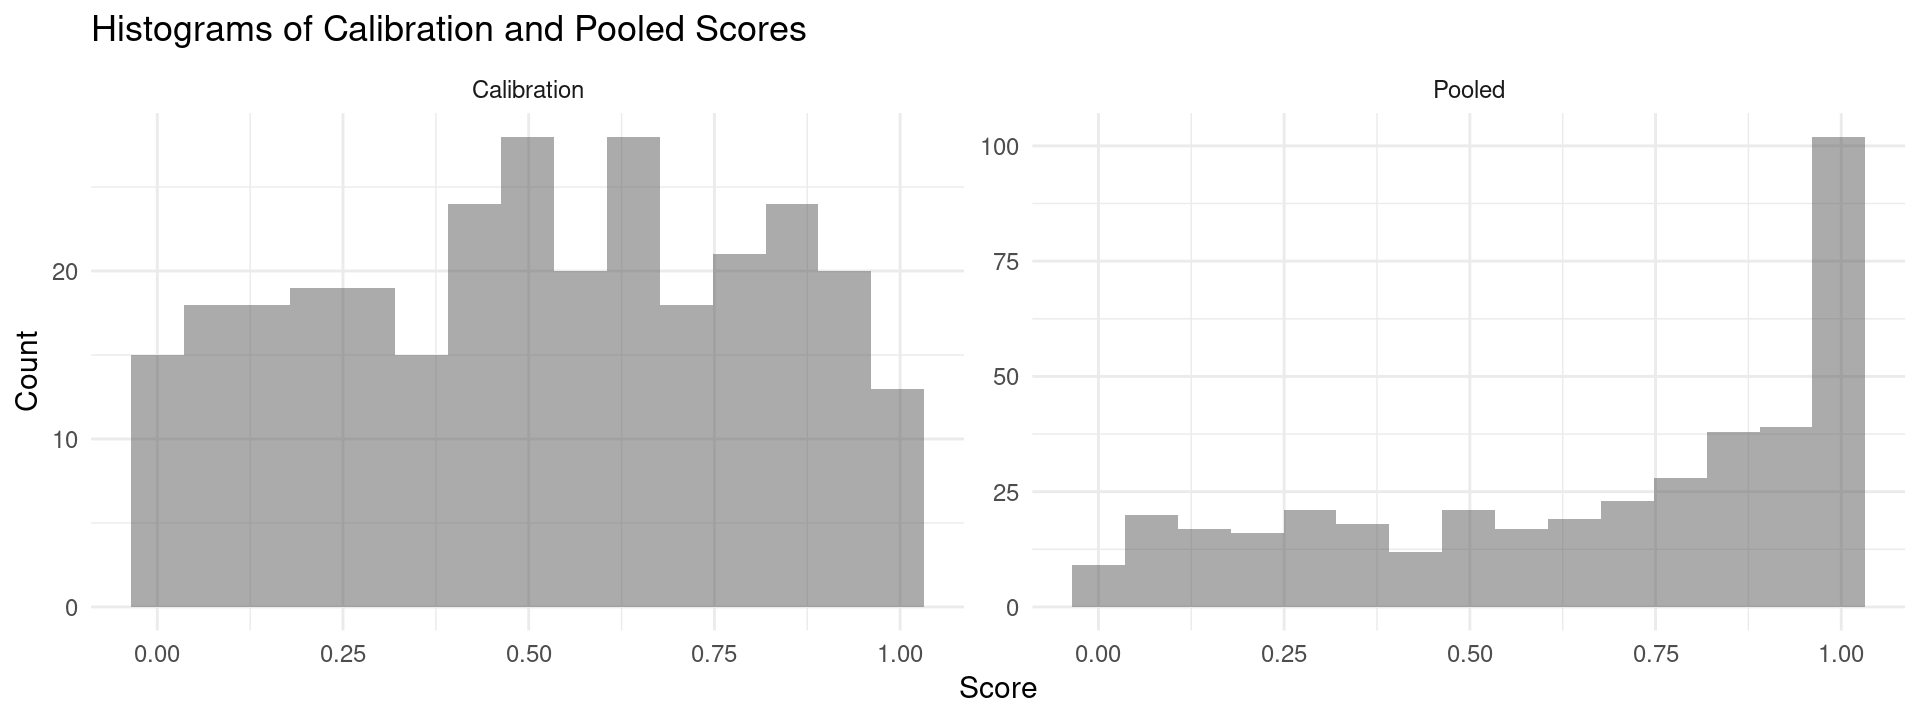

In [65]:
source("../R/utils_g.R")

S_X = data$scores.cal
S_Y = data$scores.test
prop_cal = 0.5

m = length(S_X)
n = length(S_Y)
m_2 = pmin(n, as.integer(round(prop_cal * m)))
m_1 = m - m_2

idx_X_1 = sample(m, m_1)
idx_X_2 = setdiff(1:m, idx_X_1)
S_X1 = S_X[idx_X_1]
S_X2 = S_X[idx_X_2]

S_pooled = sample(c(S_X2, S_Y))

tmp_df.1 <- tibble(score = S_X1, set = "Calibration")
tmp_df.2 <- tibble(score = S_pooled, set = "Pooled")
tmp_df <- rbind(tmp_df.1, tmp_df.2)

ggplot(tmp_df, aes(x = score)) +
  geom_histogram(alpha = 0.5, bins=15) + 
    facet_wrap(. ~ set, scales = "free_y") +
  theme_minimal(base_size = 18) +  # Increase base font size
  labs(title = "Histograms of Calibration and Pooled Scores",
       x = "Score",
       y = "Count",
       fill = "Type") +
  scale_fill_manual(values = c("Inlier" = "blue", "Outlier" = "red"))

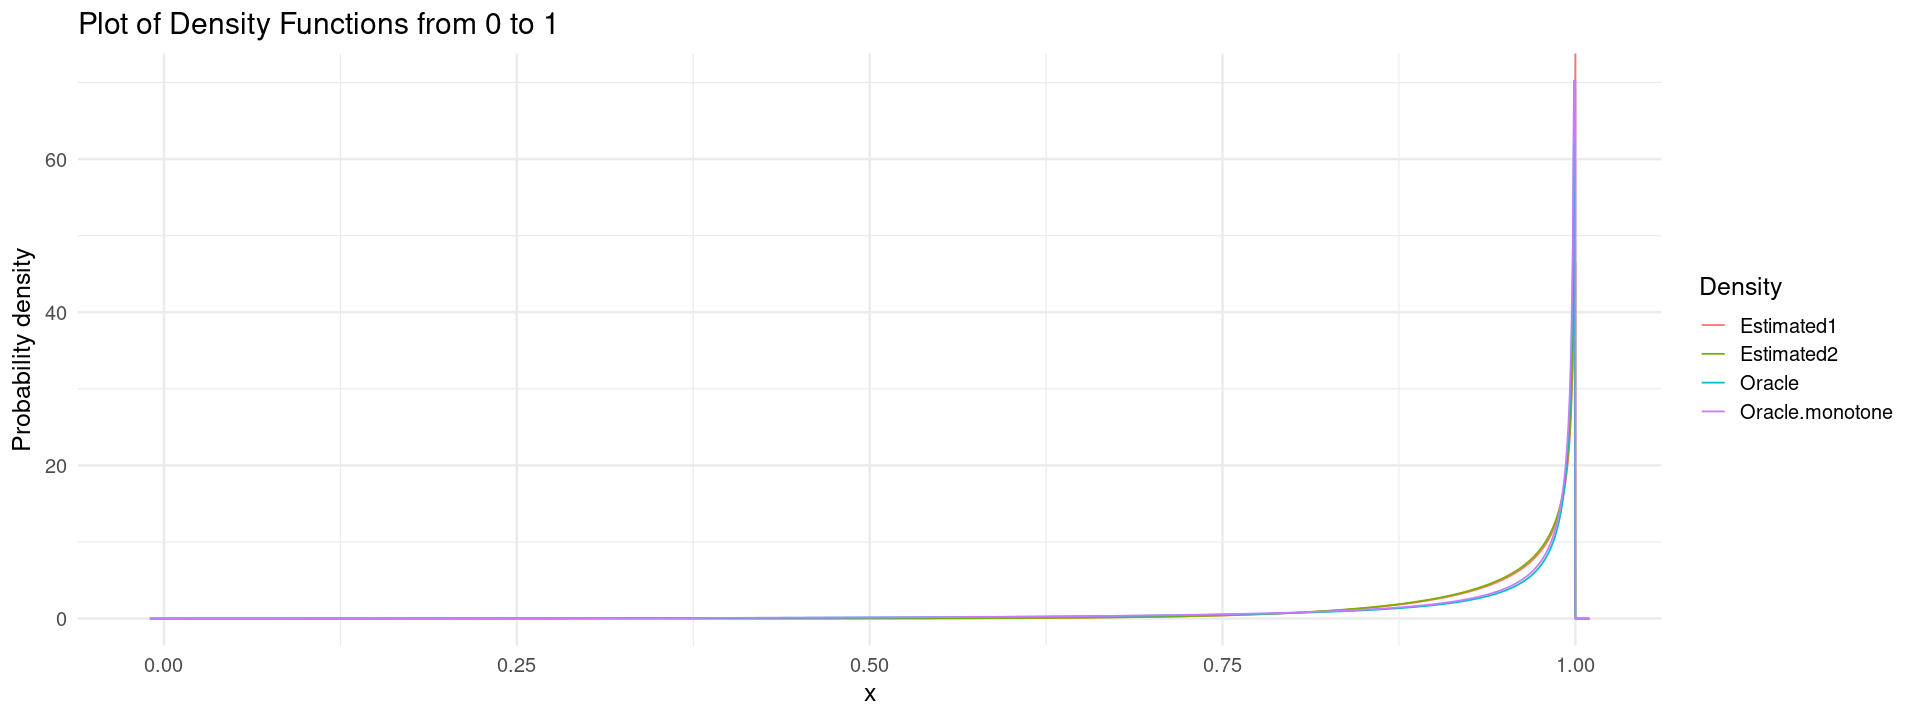

In [66]:
source("../R/utils_g.R")
#g.hat.1 <- estimate_g(S_X1, S_pooled, method="betamix")$pdf
g.hat.1 <- estimate_g(S_X1, S_pooled, method="betamix")$pdf
g.hat.2 <- estimate_g(S_X1, S_pooled, method="betamix", monotone=TRUE)$pdf
#g.hat.3 <- estimate_g(S_X1, S_pooled, method="mixmodel", monotone=NULL)$pdf
#g.hat.4 <- estimate_g(S_X1, S_pooled, method="mixmodel", monotone="increasing")$pdf

plot_density(c(Oracle=density_oracle, Oracle.monotone=density_oracle_mono, Estimated2=g.hat.2, Estimated1=g.hat.1))

#plot_density(c(Oracle=density_oracle, Oracle.monotone=density_oracle_mono, Estimated=g.hat.1, Estimated2=g.hat.2))

## Estimate the number of outliers

In [51]:
S_X = data$scores.cal
S_Y = data$scores.test

In [52]:
compute.global.pvalue.shirashi(S_X, S_Y, density_oracle, num_mc=1000)

[1] 1.581251e-09

In [60]:
d_selection_G2(S_X, S_Y, g.oracle=density_oracle, monotone=TRUE, alpha=0.1, n_perm=0, B=10^3, B_MC=10^4)

$lower.bound
[1] 38

$global.pvalue
[1] 4.403252e-07

$S
NULL

$selection.p.value
[1] 1

In [10]:
d_selection_G2(S_X, S_Y, g.oracle=NULL, fit.method="betamix", monotone=TRUE, alpha=0.1, n_perm=0, B=10^3, B_MC=10^3, seed=123)

$lower.bound
[1] 110

$global.pvalue
[1] 2.400567e-05

$S
NULL

$selection.p.value
[1] 1

In [11]:
source("../R/utils_experiments.R")
run_outlier_enumeration(data, alpha=0.1, alternative=alternative)

Method,Lower
<chr>,<dbl>
Fisher,0
WMW,2
WMW_k2,0
WMW_k3,0
Shirashi_oracle,89
Shirashi_ghat_betamix,118
